## Importing Libraries

In [608]:
import numpy as np
import pandas as pd
import regex as re

In [609]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [610]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import Birch

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

In [611]:
from sklearn.pipeline import make_pipeline

## Loading Dataset

In [612]:
dataset_train = pd.read_csv('CensusCanada2016Training.csv')

## Dataset Preparation & Data Understanding

In [613]:
dataset_train.head()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
0,4051,1441,68242.12000,1441,323,199,53,182,526,911,525,5,1343,919,424
1,2329,1026,88172.37000,1026,927,70,15,3,0,792,230,4,991,778,213
2,5276,2071,103853.38000,2071,3,607,567,651,106,1418,652,1,1903,1522,381
3,5967,2203,82796.63000,2203,133,1695,248,79,0,1397,806,0,2079,1272,807
4,4236,1419,91648.22000,1419,0,7,127,938,143,914,505,0,1348,1186,162


In [614]:
dataset_train.info() # Inspecting for data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Total Population                                                           5000 non-null   int64  
 1   Total Households                                                           5000 non-null   int64  
 2   Median Household Income (Current Year $)                                   5000 non-null   float64
 3   Total Households For Period Of Construction                                5000 non-null   int64  
 4   Total Households For Period Of Construction Built Before 1961              5000 non-null   int64  
 5   Total Households For Period Of Construction Built Between 1961 And 1980    5000 non-null   int64  
 6   Total Households For Period Of Construction Built Betwee

In [615]:
pd.options.display.float_format = "{:,.0f}".format

dataset_train.describe()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
count,"5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000","5,000"
mean,"4,867","1,928","77,241","1,928",387,555,260,238,139,"1,135",777,16,"1,811","1,182",628
std,"2,492",975,"33,372",975,417,448,258,265,222,812,891,63,898,711,594
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,"3,290","1,334","53,041","1,334",47,192,74,58,17,534,146,0,"1,258",687,201
50%,"4,655","1,825","76,207","1,825",238,470,181,143,52,"1,076",487,2,"1,724","1,112",456
75%,"6,234","2,428","95,438","2,428",613,830,369,325,157,"1,592","1,119",6,"2,281","1,570",879
max,"30,789","15,388","669,560","15,388","2,411","3,547","1,740","2,360","2,262","9,123","15,248","1,378","11,891","8,628","6,813"


In [616]:
def cleanHeaders(df):

  headers = []

  for header in df.columns:

    header = header.replace('Total Households For Period Of Construction Built', 'Total Households Built')
    header = header.replace('Total Households For Structure Type', 'Total Households For')
    header = header.replace('Low And High Rise', '')
    header = header.replace(' 190', ' 1990')

    header = header.lower()
    header = re.sub('\W', ' ', header)
    header = re.sub('^\s|\s+$', '', header)
    header = re.sub('\s+', '_', header)
    headers.append(header)
  
  return headers

In [617]:
dataset_train.columns = cleanHeaders(dataset_train)

In [618]:
dataset_train[(dataset_train.total_population <= 2500*0.75) | (dataset_train.total_population > 8000*1.25)].sort_values(by='total_population') # Outliers? (allowing a 25% threshold -- over 10% of rows -- do we drop?)

,total_population,total_households,median_household_income_current_year,total_households_for_period_of_construction,total_households_built_before_1961,total_households_built_between_1961_and_1980,total_households_built_between_1981_and_1990,total_households_built_between_1991_and_2000,total_households_built_between_2001_and_2005,total_households_for_houses,total_households_for_apartment_building,total_households_for_other_dwelling_types,total_households_for_tenure,dwellings_by_tenure_owner,dwellings_by_tenure_renter
2221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2837,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,22582,8895,"57,891",8895,706,1847,877,1324,723,6786,1896,213,8083,6008,2075
381,22748,15388,"83,230",15388,338,99,144,921,1847,127,15248,13,11891,5078,6813
1232,24665,8119,"122,510",8119,0,13,0,24,176,7313,806,0,7344,6321,1023
2440,26305,6151,"101,757",6151,31,30,23,30,93,6042,109,0,5500,5128,372


In [619]:
for c in [col for col in dataset_train if 'for' in col]:
  print('dataset_train[\''+c+'\'] + \\')

dataset_train['total_households_for_period_of_construction'] + \
dataset_train['total_households_built_before_1961'] + \
dataset_train['total_households_for_houses'] + \
dataset_train['total_households_for_apartment_building'] + \
dataset_train['total_households_for_other_dwelling_types'] + \
dataset_train['total_households_for_tenure'] + \


In [620]:
dataset_train[(dataset_train['total_households'] == \
                dataset_train['total_households_for_houses'] + \
                dataset_train['total_households_for_apartment_building'] + \
                dataset_train['total_households_for_other_dwelling_types']) == True].count()

total_population                                5000
total_households                                5000
median_household_income_current_year            5000
total_households_for_period_of_construction     5000
total_households_built_before_1961              5000
total_households_built_between_1961_and_1980    5000
total_households_built_between_1981_and_1990    5000
total_households_built_between_1991_and_2000    5000
total_households_built_between_2001_and_2005    5000
total_households_for_houses                     5000
total_households_for_apartment_building         5000
total_households_for_other_dwelling_types       5000
total_households_for_tenure                     5000
dwellings_by_tenure_owner                       5000
dwellings_by_tenure_renter                      5000
dtype: int64

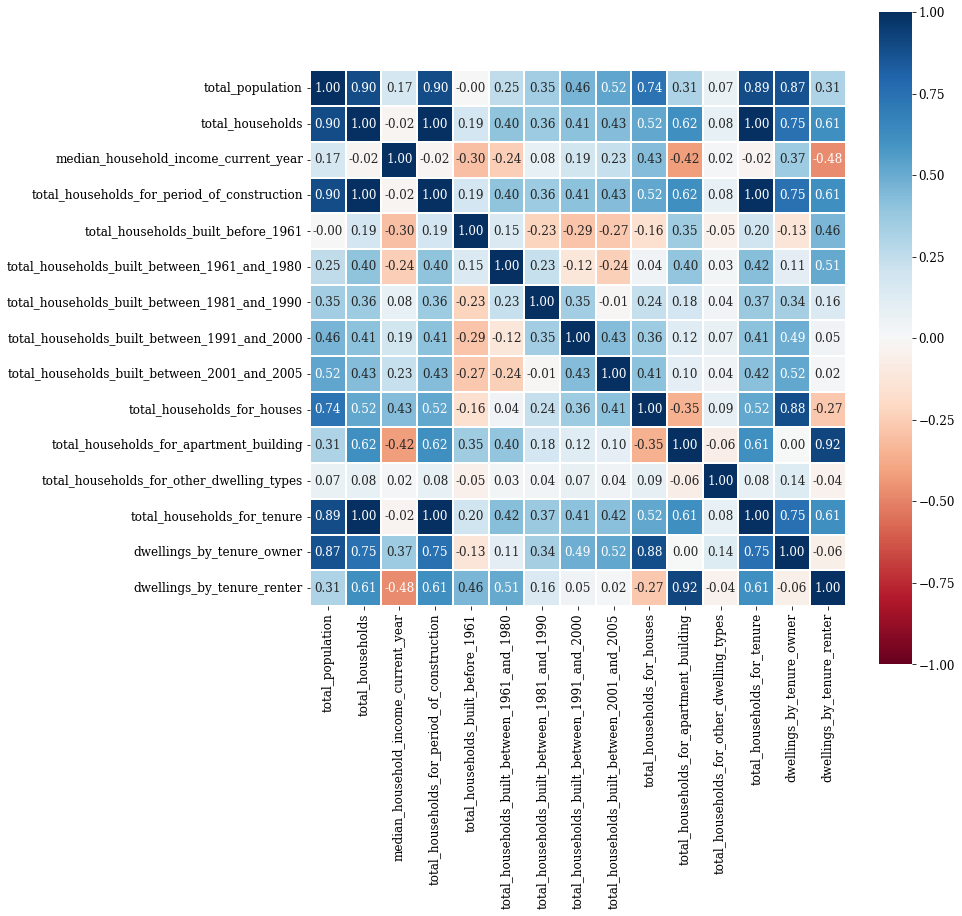

In [621]:
pd.options.display.float_format = "{:,.2f}".format

plt.figure(figsize=(12,12))
sns.heatmap(dataset_train.corr(), cmap='RdBu', annot=True, fmt='.2f', vmin=-1, square=True, linewidths=1)
plt.show()

In [622]:
def correlatedCols(df, cutoff=0.5):

  drop_pairs = set()
  cols = df.columns
  for i in range(0, df.shape[1]):
    for j in range(0, i+1):
      drop_pairs.add((cols[i], cols[j]))

  corr_unstack = pd.DataFrame(df.corr().unstack())
  corr_unstack.drop(labels=drop_pairs, inplace=True)
  corr_unstack.reset_index(inplace=True)
  corr_unstack.columns = ['Col 1', 'Col 2', 'Correlation']
  corr_unstack['Sign'] = corr_unstack['Correlation'].apply(lambda x: '+' if x >= 0 else '-')
  corr_unstack['Correlation'] = corr_unstack['Correlation'].abs()
  corr_unstack = corr_unstack.sort_values(by='Correlation', ascending=False)
  corr_unstack = corr_unstack.reset_index(drop=True)

  return corr_unstack[corr_unstack['Correlation'] > cutoff]

In [623]:
# Based on https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm, if the correlation is between:
# 0.3 to 0.5: low correlation
# 0.5 to 0.7: moderate correlation
# 0.7 to 0.9: high correlation
# 0.9 to 1.0: very high correlation

correlatedCols(dataset_train, 0.7).sort_values(by='Col 1')

,Col 1,Col 2,Correlation,Sign
0,total_households,total_households_for_period_of_construction,1.00,+
1,total_households,total_households_for_tenure,1.00,+
11,total_households,dwellings_by_tenure_owner,0.75,+
3,total_households_for_apartment_building,dwellings_by_tenure_renter,0.92,+
7,total_households_for_houses,dwellings_by_tenure_owner,0.88,+
2,total_households_for_period_of_construction,total_households_for_tenure,1.00,+
10,total_households_for_period_of_construction,dwellings_by_tenure_owner,0.75,+
9,total_households_for_tenure,dwellings_by_tenure_owner,0.75,+
4,total_population,total_households,0.90,+
5,total_population,total_households_for_period_of_construction,0.90,+


## Feature Engineering

In [624]:
dataset_train.columns

Index(['total_population', 'total_households',
       'median_household_income_current_year',
       'total_households_for_period_of_construction',
       'total_households_built_before_1961',
       'total_households_built_between_1961_and_1980',
       'total_households_built_between_1981_and_1990',
       'total_households_built_between_1991_and_2000',
       'total_households_built_between_2001_and_2005',
       'total_households_for_houses',
       'total_households_for_apartment_building',
       'total_households_for_other_dwelling_types',
       'total_households_for_tenure', 'dwellings_by_tenure_owner',
       'dwellings_by_tenure_renter'],
      dtype='object')

In [625]:
dataset_train.shape 

(5000, 15)

In [626]:
if 'average_household_size' in dataset_train.columns:
  dataset_train.drop(labels=['average_household_size'], axis=1, inplace=True)

dataset_train['average_household_size'] = dataset_train.apply(lambda x: round(x['total_population']/x['total_households'], 0) if x['total_households'] != 0 else np.nan, axis=1)

In [627]:
dataset_train['total_households_for_houses_percent'] = dataset_train['total_households_for_houses']/dataset_train['total_households']*100

In [628]:
dataset_train['total_households_for_apartment_building_percent'] = dataset_train['total_households_for_apartment_building']/dataset_train['total_households']*100
dataset_train['total_households_for_other_dwelling_types_percent'] = dataset_train['total_households_for_other_dwelling_types']/dataset_train['total_households']*100
dataset_train['total_households_for_tenure_percent'] = dataset_train['total_households_for_tenure']/dataset_train['total_households']*100

In [629]:
dataset_train['dwellings_by_tenure_owner_percent']=dataset_train['dwellings_by_tenure_owner']/dataset_train['total_households_for_tenure']*100
dataset_train['dwellings_by_tenure_renter_percent']=dataset_train['dwellings_by_tenure_renter']/dataset_train['total_households_for_tenure']*100

In [630]:
dataset_train['total_households_built_before_1961_percent'] = dataset_train['total_households_built_before_1961']/dataset_train['total_households_for_period_of_construction']*100
dataset_train['total_households_built_between_1961_and_1980_percent'] = dataset_train['total_households_built_between_1961_and_1980']/dataset_train['total_households_for_period_of_construction']*100
dataset_train['total_households_built_between_1981_and_1990_percent'] = dataset_train['total_households_built_between_1981_and_1990']/dataset_train['total_households_for_period_of_construction']*100
dataset_train['total_households_built_between_1991_and_2000_percent'] = dataset_train['total_households_built_between_1991_and_2000']/dataset_train['total_households_for_period_of_construction']*100
dataset_train['total_households_built_between_2001_and_2005_percent'] = dataset_train['total_households_built_between_2001_and_2005']/dataset_train['total_households_for_period_of_construction']*100

## Data Exploration & Outlier Elimination

In [631]:
 plt.rcParams["font.family"] = "serif"
 plt.rcParams.update({'font.size': 12})

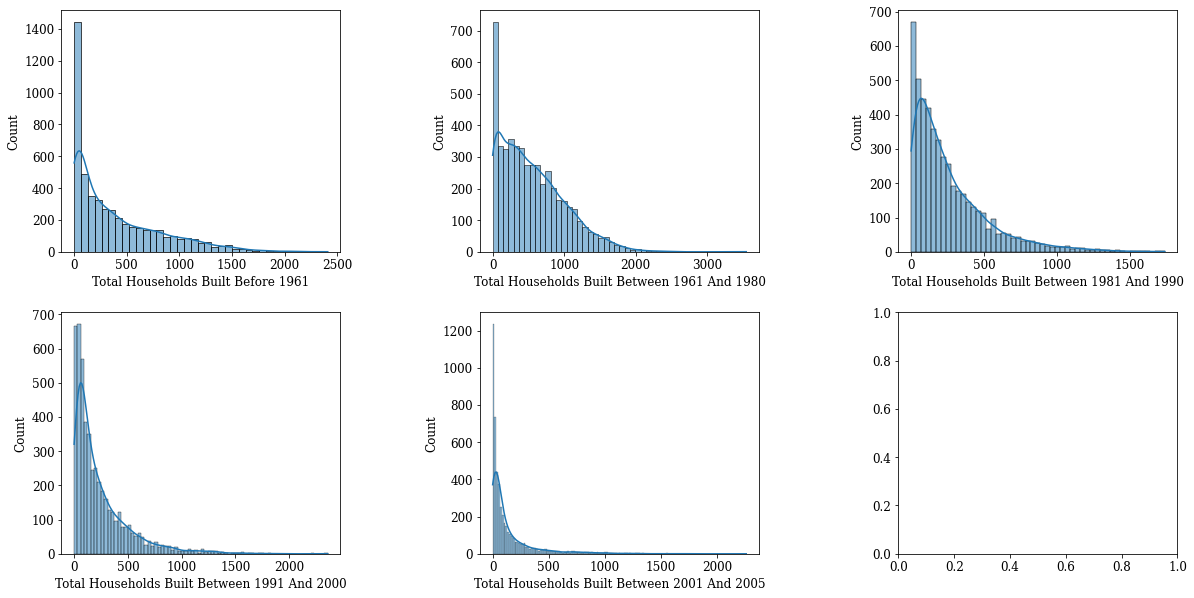

In [632]:
plot = ['total_households_built_before_1961',
       'total_households_built_between_1961_and_1980',
       'total_households_built_between_1981_and_1990',
       'total_households_built_between_1991_and_2000',
       'total_households_built_between_2001_and_2005']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.25)

axs = axs.ravel()

for i, col in enumerate(plot):
  sns.histplot(data=dataset_train, x=col, kde=True, ax=axs[i])
  axs[i].set_xlabel(col.title().replace('_', ' '))

plt.show()

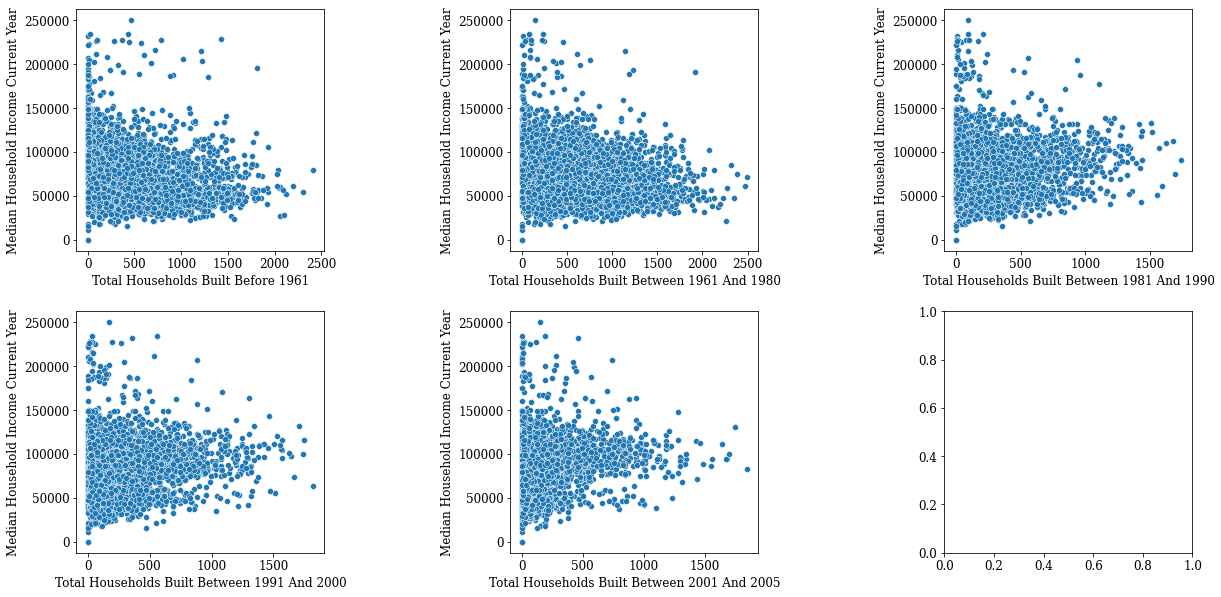

In [657]:
plot = ['total_households_built_before_1961',
       'total_households_built_between_1961_and_1980',
       'total_households_built_between_1981_and_1990',
       'total_households_built_between_1991_and_2000',
       'total_households_built_between_2001_and_2005']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.75, hspace=0.25)

axs = axs.ravel()

for i, col in enumerate(plot):
  sns.scatterplot(data=dataset_train, x=col, y='median_household_income_current_year', ax=axs[i])
  axs[i].set_xlabel(col.title().replace('_', ' ')) 
  axs[i].set_ylabel('median_household_income_current_year'.title().replace('_', ' ')) 

plt.show()

In [634]:
dataset_train[(dataset_train['total_households_built_between_1961_and_1980'] > 2.5e3) |
              (dataset_train['total_households_built_between_1991_and_2000'] > 2e3) |
              (dataset_train['total_households_built_between_2001_and_2005'] > 2e3)             
              ].shape[0]

6

In [635]:
dataset_train = dataset_train[~((dataset_train['total_households_built_between_1961_and_1980'] > 2.5e3) |
                               (dataset_train['total_households_built_between_1991_and_2000'] > 2e3) |
                               (dataset_train['total_households_built_between_2001_and_2005'] > 2e3)
                               )]

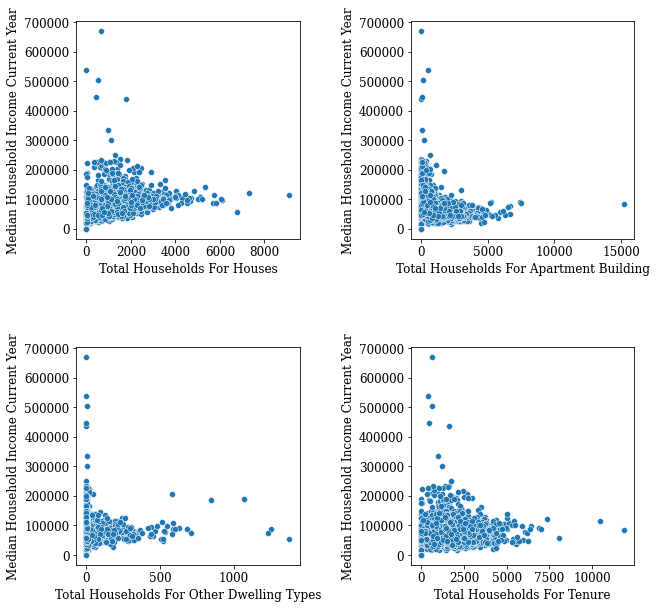

In [636]:
plot = ['total_households_for_houses',
       'total_households_for_apartment_building',
       'total_households_for_other_dwelling_types',
       'total_households_for_tenure']

fig, axs = plt.subplots(int(len(plot)/2), 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axs = axs.ravel()

for i, col in enumerate(plot):
  sns.scatterplot(data=dataset_train, x=col, y='median_household_income_current_year', ax=axs[i])
  axs[i].set_xlabel(col.title().replace('_', ' ')) 
  axs[i].set_ylabel('median_household_income_current_year'.title().replace('_', ' ')) 

plt.show()

In [637]:
dataset_train[(dataset_train['total_households_for_other_dwelling_types'] > 8e2)].shape[0]

5

In [638]:
dataset_train = dataset_train[~(dataset_train['total_households_for_other_dwelling_types'] > 8e2)]

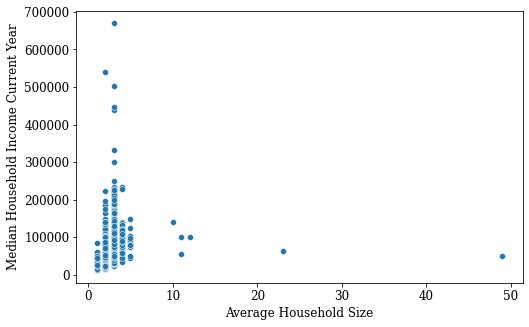

In [639]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=dataset_train, x='average_household_size', y='median_household_income_current_year')
plt.xlabel('average_household_size'.title().replace('_', ' ')) 
plt.ylabel('median_household_income_current_year'.title().replace('_', ' ')) 
plt.show()

In [640]:
dataset_train[(dataset_train['average_household_size'] > 10) | (dataset_train['median_household_income_current_year'] > 3e5)].shape[0]

12

In [641]:
dataset_train = dataset_train[~((dataset_train['average_household_size'] > 10) | 
                                (dataset_train['median_household_income_current_year'] > 3e5))]

In [642]:
dataset_train.shape

(4977, 27)

In [658]:
import warnings

In [659]:
warnings.filterwarnings('ignore')

In [660]:
dataset_train['average_household_size_cat'] = pd.cut(dataset_train.average_household_size, range(0, 5, 1), right=False)
dataset_train['total_households_for_houses_percent_cat'] = pd.cut(dataset_train.total_households_for_houses_percent, range(0, 110, 10), right=False)
dataset_train['dwellings_by_tenure_owner_percent_cat'] = pd.cut(dataset_train.dwellings_by_tenure_owner_percent, range(0, 110, 10), right=False)

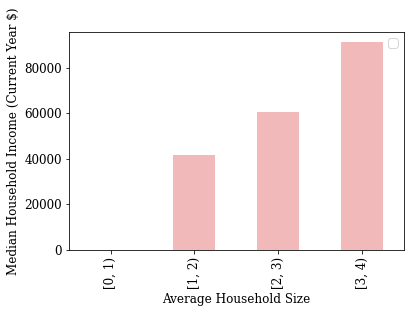

In [644]:
col = 'average_household_size_cat'

df=dataset_train.groupby([col]).mean().reset_index()
df.plot(x=col, y='median_household_income_current_year', kind="bar", color=['#f1b9b9'])
plt.xlabel(col.title().replace('_', ' ').replace(' Cat', ''))
plt.ylabel('Median Household Income (Current Year $)')
plt.legend('')
plt.show()

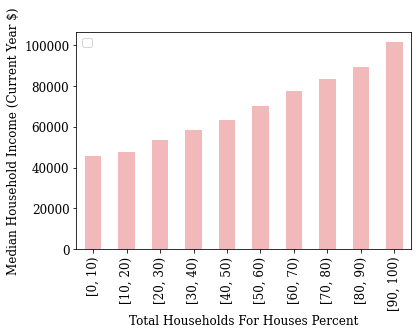

In [645]:
col = 'total_households_for_houses_percent_cat'

df=dataset_train.groupby([col]).mean().reset_index()
df.plot(x=col, y='median_household_income_current_year',kind="bar", color=['#f1b9b9'])
plt.xlabel(col.title().replace('_', ' ').replace(' Cat', ''))
plt.ylabel('Median Household Income (Current Year $)')
plt.legend('')
plt.show()

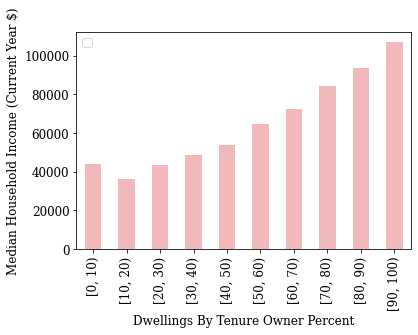

In [646]:
col = 'dwellings_by_tenure_owner_percent_cat'

df=dataset_train.groupby([col]).mean().reset_index()
df.plot(x=col, y='median_household_income_current_year',kind="bar", color=['#f1b9b9'])
plt.xlabel(col.title().replace('_', ' ').replace(' Cat', ''))
plt.ylabel('Median Household Income (Current Year $)')
plt.legend('')
plt.show()

In [647]:
print("Bottom 33.3% percentile of income is {:.2f}".format(dataset_train['median_household_income_current_year'].quantile(0.33)))
print("Bottom 66.6% percentile of income is {:.2f}".format(dataset_train['median_household_income_current_year'].quantile(0.66)))

Bottom 33.3% percentile of income is 58723.10
Bottom 66.6% percentile of income is 87715.31


In [648]:
cmap = plt.get_cmap("tab20c")
colors = cmap(np.array([13, 15, 17, 18, 20]))

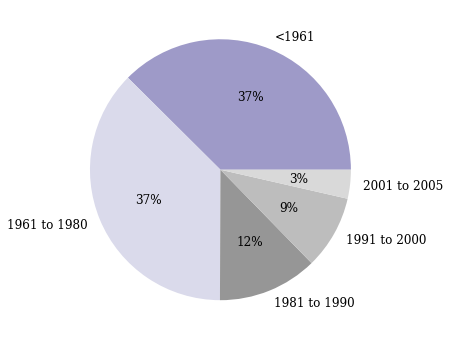

In [649]:
df = dataset_train[(dataset_train['median_household_income_current_year'] < dataset_train['median_household_income_current_year'].quantile(0.33))]

percentages = []

for col in dataset_train.columns:
  if len(re.findall('(?=.*total_households_built)(?=.*percent)', col)) != 0:
    percentages.append(df[col].mean())

plt.figure(figsize=(6,6))
plt.pie(x=percentages, labels=['<1961','1961 to 1980','1981 to 1990','1991 to 2000','2001 to 2005'], autopct='%i%%', radius=1, colors=colors)
plt.show()

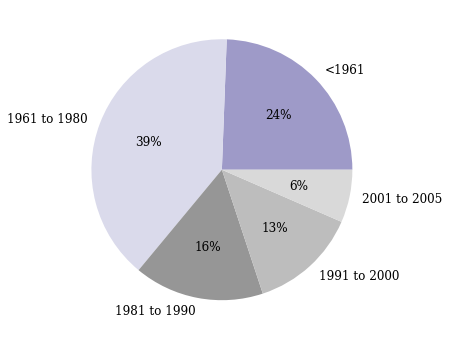

In [650]:
df = dataset_train[(dataset_train['median_household_income_current_year'] >= dataset_train['median_household_income_current_year'].quantile(0.33)) & 
                   (dataset_train['median_household_income_current_year'] < dataset_train['median_household_income_current_year'].quantile(0.66))]

percentages = []

for col in dataset_train.columns:
  if len(re.findall('(?=.*total_households_built)(?=.*percent)', col)) != 0:
    percentages.append(df[col].mean())

plt.figure(figsize=(6,6))
plt.pie(x=percentages, labels=['<1961','1961 to 1980','1981 to 1990','1991 to 2000','2001 to 2005'], autopct='%i%%', radius=1, colors=colors)
plt.show()

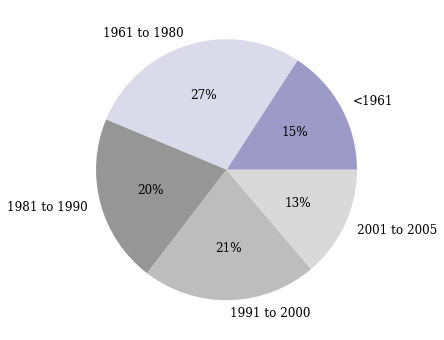

In [651]:
df = dataset_train[(dataset_train['median_household_income_current_year'] >= dataset_train['median_household_income_current_year'].quantile(0.66))]

percentages = []

for col in dataset_train.columns:
  if len(re.findall('(?=.*total_households_built)(?=.*percent)', col)) != 0:
    percentages.append(df[col].mean())

plt.figure(figsize=(6,6))
plt.pie(x=percentages, labels=['<1961','1961 to 1980','1981 to 1990','1991 to 2000','2001 to 2005'], autopct='%i%%', radius=1, colors=colors)
plt.show()

## Feature Selection

In [661]:
drop = ['total_households_for_period_of_construction',
        'total_households_built_before_1961',
        'total_households_built_between_1961_and_1980',
        'total_households_built_between_1981_and_1990',
        'total_households_built_between_1991_and_2000',
        'total_households_built_between_2001_and_2005',
          
        'total_households_for_houses',
        'total_households_for_apartment_building',
        'total_households_for_other_dwelling_types',
        'total_households_for_tenure',

        'dwellings_by_tenure_owner',
        'dwellings_by_tenure_renter',
          
        'average_household_size_cat', 
        'total_households_for_houses_percent_cat',
        'dwellings_by_tenure_owner_percent_cat']

In [662]:
dataset_train.drop(labels=drop, axis=1, inplace=True)

In [663]:
dataset_train.columns

Index(['total_population', 'total_households',
       'median_household_income_current_year', 'average_household_size',
       'total_households_for_houses_percent',
       'total_households_for_apartment_building_percent',
       'total_households_for_other_dwelling_types_percent',
       'total_households_for_tenure_percent',
       'dwellings_by_tenure_owner_percent',
       'dwellings_by_tenure_renter_percent',
       'total_households_built_before_1961_percent',
       'total_households_built_between_1961_and_1980_percent',
       'total_households_built_between_1981_and_1990_percent',
       'total_households_built_between_1991_and_2000_percent',
       'total_households_built_between_2001_and_2005_percent'],
      dtype='object')

In [664]:
correlatedCols(dataset_train, 0.7)

,Col 1,Col 2,Correlation,Sign
0,total_households_for_houses_percent,total_households_for_apartment_building_percent,0.99,-
1,dwellings_by_tenure_owner_percent,dwellings_by_tenure_renter_percent,0.98,-
2,total_population,total_households,0.90,+
3,total_households_for_apartment_building_percent,dwellings_by_tenure_renter_percent,0.87,+
4,total_households_for_houses_percent,dwellings_by_tenure_renter_percent,0.87,-
5,total_households_for_houses_percent,dwellings_by_tenure_owner_percent,0.85,+
6,total_households_for_apartment_building_percent,dwellings_by_tenure_owner_percent,0.85,-
7,median_household_income_current_year,dwellings_by_tenure_owner_percent,0.72,+
8,median_household_income_current_year,dwellings_by_tenure_renter_percent,0.72,-


In [665]:
dataset_train.drop(labels=['total_households_for_houses_percent'], axis=1, inplace=True)
correlatedCols(dataset_train, 0.7)

,Col 1,Col 2,Correlation,Sign
0,dwellings_by_tenure_owner_percent,dwellings_by_tenure_renter_percent,0.98,-
1,total_population,total_households,0.90,+
2,total_households_for_apartment_building_percent,dwellings_by_tenure_renter_percent,0.87,+
3,total_households_for_apartment_building_percent,dwellings_by_tenure_owner_percent,0.85,-
4,median_household_income_current_year,dwellings_by_tenure_owner_percent,0.72,+
5,median_household_income_current_year,dwellings_by_tenure_renter_percent,0.72,-


In [666]:
dataset_train.drop(labels=['total_households'], axis=1, inplace=True)
correlatedCols(dataset_train, 0.7)

,Col 1,Col 2,Correlation,Sign
0,dwellings_by_tenure_owner_percent,dwellings_by_tenure_renter_percent,0.98,-
1,total_households_for_apartment_building_percent,dwellings_by_tenure_renter_percent,0.87,+
2,total_households_for_apartment_building_percent,dwellings_by_tenure_owner_percent,0.85,-
3,median_household_income_current_year,dwellings_by_tenure_owner_percent,0.72,+
4,median_household_income_current_year,dwellings_by_tenure_renter_percent,0.72,-


In [667]:
dataset_train.drop(labels=['dwellings_by_tenure_renter_percent'], axis=1, inplace=True)
correlatedCols(dataset_train, 0.7)

,Col 1,Col 2,Correlation,Sign
0,total_households_for_apartment_building_percent,dwellings_by_tenure_owner_percent,0.85,-
1,median_household_income_current_year,dwellings_by_tenure_owner_percent,0.72,+


In [668]:
dataset_train.columns

Index(['total_population', 'median_household_income_current_year',
       'average_household_size',
       'total_households_for_apartment_building_percent',
       'total_households_for_other_dwelling_types_percent',
       'total_households_for_tenure_percent',
       'dwellings_by_tenure_owner_percent',
       'total_households_built_before_1961_percent',
       'total_households_built_between_1961_and_1980_percent',
       'total_households_built_between_1981_and_1990_percent',
       'total_households_built_between_1991_and_2000_percent',
       'total_households_built_between_2001_and_2005_percent'],
      dtype='object')

In [669]:
dataset_train.drop(labels=['total_households_built_between_2001_and_2005_percent'], axis=1, inplace=True)
dataset_train.columns

Index(['total_population', 'median_household_income_current_year',
       'average_household_size',
       'total_households_for_apartment_building_percent',
       'total_households_for_other_dwelling_types_percent',
       'total_households_for_tenure_percent',
       'dwellings_by_tenure_owner_percent',
       'total_households_built_before_1961_percent',
       'total_households_built_between_1961_and_1980_percent',
       'total_households_built_between_1981_and_1990_percent',
       'total_households_built_between_1991_and_2000_percent'],
      dtype='object')

## Clustering (K-Means)

In [670]:
X = np.array(np.array(dataset_train.iloc[:, :].dropna()))

In [671]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# X = scaler.fit_transform(X)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# X = scaler.fit_transform(X)

In [672]:
distortions = []
clusters = range(2, 10)
for k in clusters:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

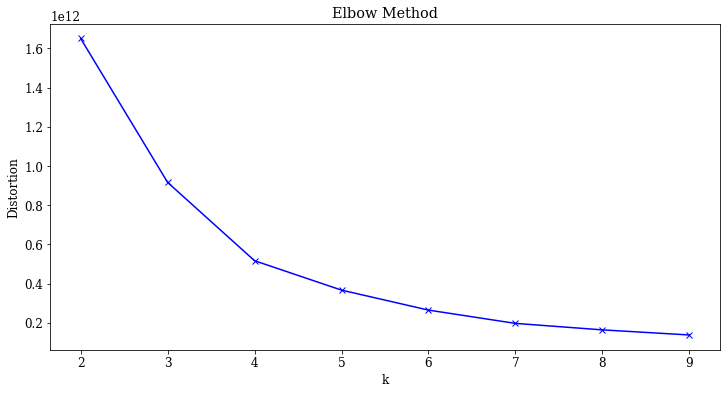

In [673]:
plt.figure(figsize=(12,6))
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [674]:
clusters = range(2,10)

for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, labels)
    print('n_clusters = {}; avg. silhouette_score = {:.5f}'.format(k, silhouette_avg))

n_clusters = 2; avg. silhouette_score = 0.56314
n_clusters = 3; avg. silhouette_score = 0.56222
n_clusters = 4; avg. silhouette_score = 0.57429
n_clusters = 5; avg. silhouette_score = 0.53366
n_clusters = 6; avg. silhouette_score = 0.49091
n_clusters = 7; avg. silhouette_score = 0.49017
n_clusters = 8; avg. silhouette_score = 0.47475
n_clusters = 9; avg. silhouette_score = 0.46166


In [675]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
labels = kmeans.predict(X)

In [676]:
dataset_clustered = pd.concat([pd.DataFrame(X, columns=dataset_train.columns), pd.DataFrame(labels, columns=['cluster'])], axis=1)

## Scatter Plots (K-Means)

In [677]:
dataset_clustered.columns

Index(['total_population', 'median_household_income_current_year',
       'average_household_size',
       'total_households_for_apartment_building_percent',
       'total_households_for_other_dwelling_types_percent',
       'total_households_for_tenure_percent',
       'dwellings_by_tenure_owner_percent',
       'total_households_built_before_1961_percent',
       'total_households_built_between_1961_and_1980_percent',
       'total_households_built_between_1981_and_1990_percent',
       'total_households_built_between_1991_and_2000_percent', 'cluster'],
      dtype='object')

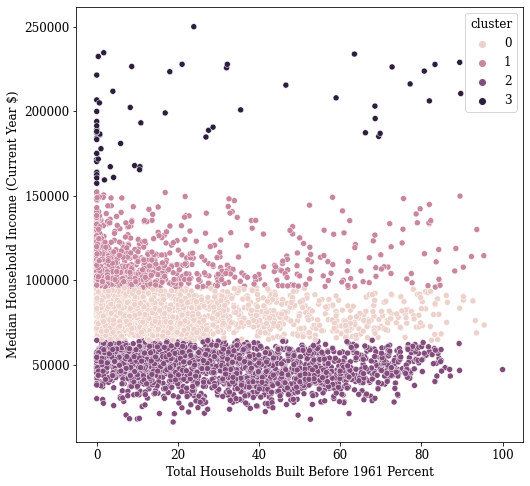

In [678]:
col = 'total_households_built_before_1961_percent'

plt.figure(figsize=(8,8))
sns.scatterplot(x=col , y='median_household_income_current_year', data=dataset_clustered, hue='cluster')
plt.xlabel(col.title().replace('_', ' ')) 
plt.ylabel('Median Household Income (Current Year $)') 
plt.show()

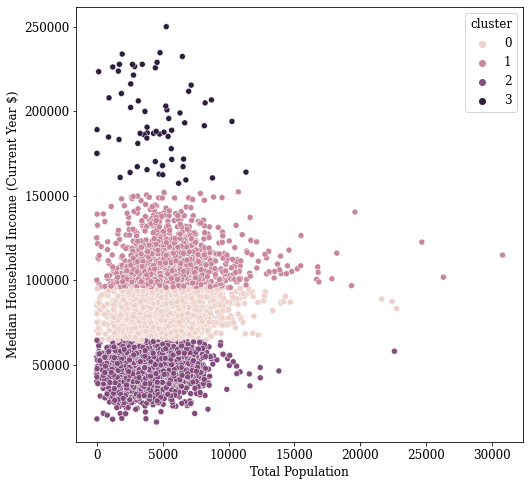

In [679]:
col = 'total_population'

plt.figure(figsize=(8,8))
sns.scatterplot(x=col , y='median_household_income_current_year', data=dataset_clustered, hue='cluster')
plt.xlabel(col.title().replace('_', ' ')) 
plt.ylabel('Median Household Income (Current Year $)') 
plt.show()

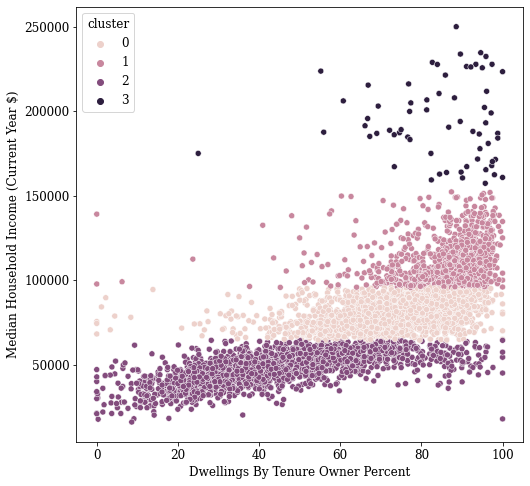

In [680]:
col = 'dwellings_by_tenure_owner_percent'

plt.figure(figsize=(8,8))
sns.scatterplot(x=col , y='median_household_income_current_year', data=dataset_clustered, hue='cluster')
plt.xlabel(col.title().replace('_', ' ')) 
plt.ylabel('Median Household Income (Current Year $)') 
plt.show()

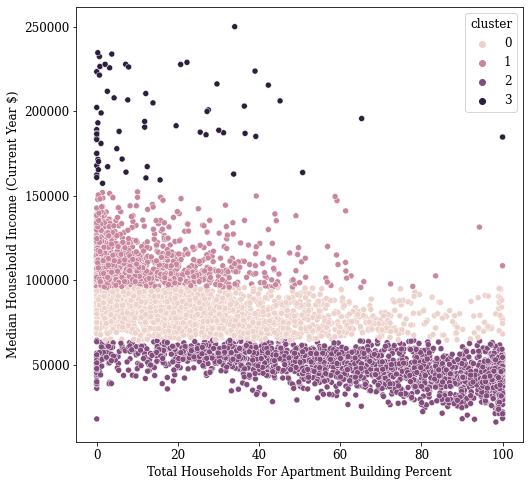

In [681]:
col = 'total_households_for_apartment_building_percent'

plt.figure(figsize=(8,8))
sns.scatterplot(x=col , y='median_household_income_current_year', data=dataset_clustered, hue='cluster')
plt.xlabel(col.title().replace('_', ' ')) 
plt.ylabel('Median Household Income (Current Year $)') 
plt.show()

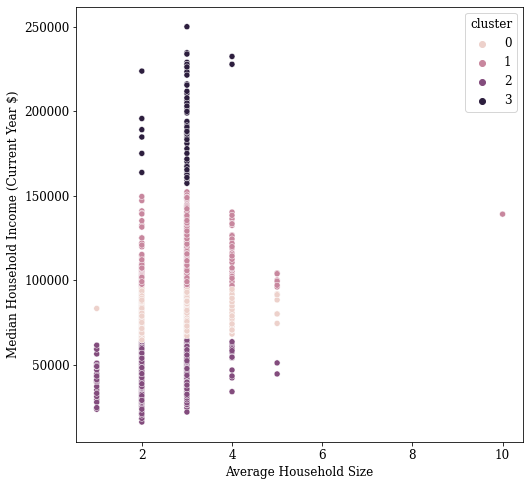

In [682]:
col = 'average_household_size'

plt.figure(figsize=(8,8))
sns.scatterplot(x=col , y='median_household_income_current_year', data=dataset_clustered, hue='cluster')
plt.xlabel(col.title().replace('_', ' ')) 
plt.ylabel('Median Household Income (Current Year $)') 
plt.show()

In [683]:
dataset_clustered.groupby("cluster").mean().T

cluster,0,1,2,3
total_population,"5,098.28","5,681.13","4,206.24","4,363.86"
median_household_income_current_year,"80,786.24","110,587.80","48,012.91","194,717.31"
average_household_size,2.65,3.00,2.23,2.94
total_households_for_apartment_building_percent,28.21,11.84,63.09,14.77
total_households_for_other_dwelling_types_percent,1.19,0.70,1.03,1.69
total_households_for_tenure_percent,94.42,94.04,94.49,93.85
dwellings_by_tenure_owner_percent,74.14,86.69,44.56,84.39
total_households_built_before_1961_percent,18.22,11.52,33.05,22.39
total_households_built_between_1961_and_1980_percent,31.63,20.92,33.84,18.20
total_households_built_between_1981_and_1990_percent,14.68,16.75,11.21,12.72


## Clustering (BIRCH)

In [684]:
birch = Birch(branching_factor=50, n_clusters=4, threshold=1.5)
birch.fit(X)

Birch(n_clusters=4, threshold=1.5)

In [685]:
labels_birch = birch.predict(X)

In [686]:
dataset_clustered_birch = pd.concat([pd.DataFrame(X, columns=dataset_train.columns), pd.DataFrame(labels_birch, columns=['birch_cluster'])], axis=1)
dataset_clustered_birch.groupby("birch_cluster").mean().T

birch_cluster,0,1,2,3
total_population,"5,564.21","4,203.71","5,166.72","4,363.86"
median_household_income_current_year,"111,005.05","47,780.93","80,828.08","194,717.31"
average_household_size,2.99,2.22,2.65,2.94
total_households_for_apartment_building_percent,11.76,63.45,28.12,14.77
total_households_for_other_dwelling_types_percent,0.76,1.04,1.15,1.69
total_households_for_tenure_percent,94.10,94.49,94.39,93.85
dwellings_by_tenure_owner_percent,86.72,44.26,74.22,84.39
total_households_built_before_1961_percent,11.65,33.17,18.12,22.39
total_households_built_between_1961_and_1980_percent,21.16,33.87,31.31,18.20
total_households_built_between_1981_and_1990_percent,16.95,11.17,14.59,12.72


## Part (b): (f)

In [687]:
dataset_train_2 = dataset_train.drop(labels='median_household_income_current_year', axis=1)

In [688]:
X = np.array(np.array(dataset_train_2.iloc[:, :].dropna()))

In [689]:
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

In [690]:
def modelBuilder(n=2):
  models = {}

  models['K-Means'] = KMeans(n_clusters=n)
  models['BIRCH'] = Birch(n_clusters=n)
  models['Agglomerative'] = AgglomerativeClustering(n_clusters=n)
  models['Mini-Batch K-Means'] = MiniBatchKMeans(n_clusters=n)

  return models

In [691]:
results = {'K-Means': {},
           'BIRCH': {},
           'Agglomerative': {},
           'Mini-Batch K-Means': {}}

backup = {'K-Means': {},
           'BIRCH': {},
           'Agglomerative': {},
           'Mini-Batch K-Means': {}}

clusters = list(range(2, 10))

for c in clusters:
  print('\nNumber of clusters = {}'.format(c))
  models = modelBuilder(n=c)
  for m in models.keys():
    model = models[m]
    model.fit(X)
    sc = silhouette_score(X, model.labels_)
    print('Silhouette score for {} using {} clusters = {:.4f} '.format(m, c, sc))
    results[m][c] = sc
    backup[m][c] = model


Number of clusters = 2
Silhouette score for K-Means using 2 clusters = 0.5506 
Silhouette score for BIRCH using 2 clusters = 0.5492 
Silhouette score for Agglomerative using 2 clusters = 0.5492 
Silhouette score for Mini-Batch K-Means using 2 clusters = 0.5518 

Number of clusters = 3
Silhouette score for K-Means using 3 clusters = 0.5193 
Silhouette score for BIRCH using 3 clusters = 0.5514 
Silhouette score for Agglomerative using 3 clusters = 0.5514 
Silhouette score for Mini-Batch K-Means using 3 clusters = 0.5257 

Number of clusters = 4
Silhouette score for K-Means using 4 clusters = 0.5222 
Silhouette score for BIRCH using 4 clusters = 0.5070 
Silhouette score for Agglomerative using 4 clusters = 0.5070 
Silhouette score for Mini-Batch K-Means using 4 clusters = 0.5235 

Number of clusters = 5
Silhouette score for K-Means using 5 clusters = 0.5185 
Silhouette score for BIRCH using 5 clusters = 0.4886 
Silhouette score for Agglomerative using 5 clusters = 0.4886 
Silhouette scor

In [692]:
pd.set_option('display.float_format', '{:.5f}'.format)
results_df = pd.DataFrame(results)

results_df

,K-Means,BIRCH,Agglomerative,Mini-Batch K-Means
2,0.55060,0.54923,0.54923,0.55178
3,0.51931,0.55136,0.55136,0.52568
4,0.52225,0.50702,0.50702,0.52351
5,0.51851,0.48857,0.48857,0.51351
6,0.52335,0.49051,0.49051,0.49082
7,0.52370,0.48915,0.48915,0.48894
8,0.52546,0.49034,0.49034,0.50812
9,0.52109,0.48214,0.48214,0.49984


In [693]:
results_df.unstack().max()

0.5517847336744915

In [695]:
selected = backup['BIRCH'][3]

## Part (b): (g), (h)

In [708]:
clustered = pd.concat([dataset_train.dropna().reset_index(drop=True), pd.DataFrame(selected.predict(X), columns=['cluster'])], axis=1)

In [709]:
clustered.groupby('cluster').mean().T

cluster,0,1,2
total_population,3415.65030,6978.39756,16187.37778
median_household_income_current_year,73632.05895,81810.10086,100479.13067
average_household_size,2.47744,2.72313,3.04444
total_households_for_apartment_building_percent,38.63925,35.47575,17.57165
total_households_for_other_dwelling_types_percent,1.25002,0.68234,0.35705
total_households_for_tenure_percent,94.78237,93.75586,90.46174
dwellings_by_tenure_owner_percent,63.64241,69.77728,82.41369
total_households_built_before_1961_percent,27.54599,14.28083,1.80245
total_households_built_between_1961_and_1980_percent,31.95260,26.89332,4.30864
total_households_built_between_1981_and_1990_percent,13.43481,14.74634,3.44494


In [710]:
clustered['cluster'] = clustered['cluster'].replace({1:'medium-income', 0:'low-income', 2:'high-income'})
clustered = clustered.sort_values(by='cluster').reset_index(drop=True)

In [711]:
clustered_l = clustered[clustered['cluster'] == 'low-income'].drop(labels='cluster', axis=1)
clustered_m = clustered[clustered['cluster'] == 'medium-income'].drop(labels='cluster', axis=1)
clustered_h = clustered[clustered['cluster'] == 'high-income'].drop(labels='cluster', axis=1)

In [712]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [713]:
def prepareData(df, y):

  X = df.drop(labels=y, axis=1)
  y = df[y]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test, scaler

In [714]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

In [715]:
models = {'Linear Regression':LinearRegression(),
          'Ridge Regression':Ridge(),
          'Lasso Regression':Lasso(),
          'Random Forest Regressor':RandomForestRegressor(),
          'SVR':SVR()}

results = {'Linear Regression':{},
          'Ridge Regression':{},
          'Lasso Regression':{},
          'Random Forest Regressor':{},
          'SVR':{}}

backup = {'Linear Regression':[],
          'Ridge Regression':[],
          'Lasso Regression':[],
          'Random Forest Regressor':[],
          'SVR':[]}

cluster_results = []

In [716]:
for dataset in [clustered_l, clustered_m, clustered_h]:
  data = dataset

  X_train, X_test, y_train, y_test, scaler = prepareData(data, 'median_household_income_current_year')

  for m in models.keys(): 
    # print('\n'+m)
    model = models[m]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    results[m]['MAE'] = mae
    results[m]['MSE'] = mse
    results[m]['RMSE'] = rmse

    backup[m].append(model)
    backup[m].append(scaler)

    # print('MAE:', mae)
    # print('MSE:', mse)
    # print('RMSE:', rmse)

  for d in range(2,4):
    # print('\nDegree: ',d)
    polreg = PolynomialFeatures(degree=d)

    model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    X_train = polreg.fit_transform(X_train)
    X_test = polreg.transform(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    m = 'Polynomial Regression ({})'.format(d)

    results[m] = {}
    
    results[m]['MAE'] = mae
    results[m]['MSE'] = mse
    results[m]['RMSE'] = rmse

    # print('MAE:', mae)
    # print('MSE:', mse)
    # print('RMSE:', rmse)

  pd.set_option('display.float_format', '{:.5f}'.format)
  results_df = pd.DataFrame(results)

  # print('\n')
  cluster_results.append(results_df)

In [717]:
cluster_results[0] # low-income

,Linear Regression,Ridge Regression,Lasso Regression,Random Forest Regressor,SVR,Polynomial Regression (2),Polynomial Regression (3)
MAE,13872.66522,13872.88646,13872.82039,12796.13822,23748.69750,13872.66522,13880.98999
MSE,450749603.04855,450753844.35767,450764588.19242,393418479.70171,926804808.16134,450749603.04855,783315152.59318
RMSE,21230.86440,21230.96428,21231.21730,19834.77955,30443.46906,21230.86440,27987.76791


In [718]:
cluster_results[1] # medium-income

,Linear Regression,Ridge Regression,Lasso Regression,Random Forest Regressor,SVR,Polynomial Regression (2),Polynomial Regression (3)
MAE,11703.38342,11702.32705,11703.38320,11147.12986,22000.11198,11703.38342,11182.36853
MSE,320834150.99092,320840949.10655,320844566.77251,299991917.40000,816435263.79941,320834150.99092,308996300.94211
RMSE,17911.84387,17912.03364,17912.13462,17320.27475,28573.33134,17911.84387,17578.29061


In [719]:
cluster_results[2] # high-income

,Linear Regression,Ridge Regression,Lasso Regression,Random Forest Regressor,SVR,Polynomial Regression (2),Polynomial Regression (3)
MAE,21900.01657,21315.74938,21895.45250,17370.29338,15542.64306,21900.01657,87499.11717
MSE,670854633.83297,627712492.50134,670504033.71906,429870434.44375,348024166.02506,670854633.83297,37202564422.22511
RMSE,25900.86164,25054.19112,25894.09264,20733.31701,18655.40581,25900.86164,192879.66306


## Predictions

In [752]:
dataset_test = pd.read_csv('CensusCanada2016Test.csv')

In [753]:
dataset_test.columns = cleanHeaders(dataset_test)

In [754]:
if 'average_household_size' in dataset_test.columns:
  dataset_test.drop(labels=['average_household_size'], axis=1, inplace=True)

dataset_test['average_household_size'] = dataset_test.apply(lambda x: round(x['total_population']/x['total_households'], 0) if x['total_households'] != 0 else np.nan, axis=1)

In [755]:
dataset_test['total_households_for_houses_percent'] = dataset_test['total_households_for_houses']/dataset_test['total_households']*100

In [756]:
dataset_test['total_households_for_apartment_building_percent'] = dataset_test['total_households_for_apartment_building']/dataset_test['total_households']*100
dataset_test['total_households_for_other_dwelling_types_percent'] = dataset_test['total_households_for_other_dwelling_types']/dataset_test['total_households']*100
dataset_test['total_households_for_tenure_percent'] = dataset_test['total_households_for_tenure']/dataset_test['total_households']*100

In [757]:
dataset_test['dwellings_by_tenure_owner_percent']=dataset_test['dwellings_by_tenure_owner']/dataset_test['total_households_for_tenure']*100
dataset_test['dwellings_by_tenure_renter_percent']=dataset_test['dwellings_by_tenure_renter']/dataset_test['total_households_for_tenure']*100

In [758]:
dataset_test['total_households_built_before_1961_percent'] = dataset_test['total_households_built_before_1961']/dataset_test['total_households_for_period_of_construction']*100
dataset_test['total_households_built_between_1961_and_1980_percent'] = dataset_test['total_households_built_between_1961_and_1980']/dataset_test['total_households_for_period_of_construction']*100
dataset_test['total_households_built_between_1981_and_1990_percent'] = dataset_test['total_households_built_between_1981_and_1990']/dataset_test['total_households_for_period_of_construction']*100
dataset_test['total_households_built_between_1991_and_2000_percent'] = dataset_test['total_households_built_between_1991_and_2000']/dataset_test['total_households_for_period_of_construction']*100
dataset_test['total_households_built_between_2001_and_2005_percent'] = dataset_test['total_households_built_between_2001_and_2005']/dataset_test['total_households_for_period_of_construction']*100

In [759]:
drop = ['total_households_for_period_of_construction',
        'total_households_built_before_1961',
        'total_households_built_between_1961_and_1980',
        'total_households_built_between_1981_and_1990',
        'total_households_built_between_1991_and_2000',
        'total_households_built_between_2001_and_2005',
          
        'total_households_for_houses',
        'total_households_for_apartment_building',
        'total_households_for_other_dwelling_types',
        'total_households_for_tenure',

        'dwellings_by_tenure_owner',
        'dwellings_by_tenure_renter']

dataset_test.drop(labels=drop, axis=1, inplace=True)

In [760]:
dataset_test.drop(labels=['total_households_for_houses_percent'], axis=1, inplace=True)
dataset_test.drop(labels=['total_households'], axis=1, inplace=True)
dataset_test.drop(labels=['dwellings_by_tenure_renter_percent'], axis=1, inplace=True)
dataset_test.drop(labels=['total_households_built_between_2001_and_2005_percent'], axis=1, inplace=True)

In [761]:
for col in dataset_test.columns:
  dataset_test[col].fillna(dataset_test[col].mean(), inplace=True)

In [762]:
cluster_pred = pd.DataFrame(selected.predict(np.array(dataset_test)), columns=['cluster'])

In [763]:
clustered_test = pd.concat([dataset_test, cluster_pred], axis=1)

clustered_test['cluster'] = clustered_test['cluster'].replace({1:'medium-income', 0:'low-income', 2:'high-income'})

In [764]:
clustered_test.groupby('cluster').mean().T

cluster,high-income,low-income,medium-income
total_population,15381.25000,3360.11187,7037.54182
average_household_size,3.12500,2.53528,2.72364
total_households_for_apartment_building_percent,24.76948,38.68339,34.97134
total_households_for_other_dwelling_types_percent,0.03761,1.85862,0.59342
total_households_for_tenure_percent,91.15849,93.72305,93.36478
dwellings_by_tenure_owner_percent,81.54591,64.38696,70.65683
total_households_built_before_1961_percent,1.46024,26.82730,13.37595
total_households_built_between_1961_and_1980_percent,5.64445,31.66791,26.84244
total_households_built_between_1981_and_1990_percent,3.75485,14.08096,13.69998
total_households_built_between_1991_and_2000_percent,7.99396,11.16082,14.90972


In [765]:
clustered_test_l = clustered_test[clustered_test['cluster'] == 'low-income'].drop(labels='cluster', axis=1)
clustered_test_m = clustered_test[clustered_test['cluster'] == 'medium-income'].drop(labels='cluster', axis=1)
clustered_test_h = clustered_test[clustered_test['cluster'] == 'high-income'].drop(labels='cluster', axis=1)

In [766]:
datasets = [clustered_test_l, clustered_test_m, clustered_test_h]

In [767]:
scalers = backup['Random Forest Regressor'][1::2]
models = backup['Random Forest Regressor'][0::2]

In [768]:
predictions = []

for dataset, scaler, model in zip(datasets, scalers, models):
  X_test = scaler.transform(dataset)
  prediction = pd.DataFrame(model.predict(X_test), index=dataset.index)
  predictions.append(prediction)

In [769]:
predictions_df = pd.concat([predictions[0], predictions[1], predictions[2]])

In [770]:
final = predictions_df.sort_index()

In [771]:
dataset_test.shape[0] == len(final)

True

In [772]:
txt_file = open("Team9predictions.txt", 'w')
for row in final[0].to_list():
  txt_file.write(str(row))
  txt_file.write('\n')
txt_file.close()